#Active Session 7: State Space Models

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cihan-ates/data-driven-engineering/blob/master/DDE_II_Advanced_Topics/Lecture%209/Lecture_9.ipynb)


#Important Note

Lecture notes and notebooks must not be copied and/or distributed without the express permission of ITS.





#1. Problem Definition: Short Term Load Forecasting

Energy landscape is changing with the increase in the share of renewables and change in user behaviour. There are important challenges waiting to be solved within the energy sector and the demand forecasting can help solving critical business problems. Feel free to explore the additional content at the end from GE.

In this dataset, we will perform load forecasting within the context of energy demand. It is an open-access data published as the appendix Hong et al. (2016). The data consists of three years of hourly electricity load and temperatures. The temperature data will serve as a typical additional feature for load forecasting -- depending on how you formulate your solution, you may need to predict the temperature as well!


# 2. Preparing the enviroment

Import the Python libraries that we will need to (i) load the data, (ii) analyze it, (iii) create our model, (iv) process the results.

In [1]:
!pip install ipython-autotime
%load_ext autotime

time: 1.72 ms (started: 2021-07-01 17:00:43 +00:00)


## Libraries

In [2]:
#Local Installations
!pip install statsmodels

time: 2.33 s (started: 2021-07-01 17:00:43 +00:00)


In [3]:
#Importing the necessary libraries
import math
import numpy as np
import pandas as pd
import datetime as dt
import os
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
import statsmodels.api as sm
import warnings
import matplotlib.dates as mdates
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


time: 1.19 s (started: 2021-07-01 17:00:45 +00:00)


In [4]:
# Data Preparation and Scoring
from sklearn import preprocessing as pp
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from matplotlib.colors import LogNorm
import collections

time: 138 ms (started: 2021-07-01 17:00:47 +00:00)


In [140]:
# ML Algorithms to be used

from statsmodels.tsa.statespace.sarimax import SARIMAX
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from tensorflow_probability import sts
tf.enable_v2_behavior()

time: 3.05 ms (started: 2021-07-01 18:56:47 +00:00)


In [6]:
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))


SUCCESS: Found GPU: /device:GPU:0
time: 5.06 s (started: 2021-07-01 17:00:49 +00:00)


# 3. Pre-processing


## Loading the Data

We need to upload the dataset to Colab enviroment. Pandas library is a practical way to load and read the data from an url. 

The data is on ILIAS so this week you need to upload the data from your local pc / by using Google Drive link. 

In [7]:
# Loading the data
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

time: 31.4 s (started: 2021-07-01 17:00:54 +00:00)


In [8]:
downloaded = drive.CreateFile({'id':'1cqX7sRtu_J0Q8nMRuwb0YbMjb6jN7lyb'}) 
downloaded.GetContentFile('energy.csv')
data = pd.read_csv('energy.csv')  #,parse_dates=[['Date', 'Hour']]) if date and hour to be merged here.
data.head()

,Date,Hour,load,T
0,01/01/2004,1,NaN,37.33
1,01/01/2004,2,NaN,37.67
2,01/01/2004,3,NaN,37.00
3,01/01/2004,4,NaN,36.33
4,01/01/2004,5,NaN,36.00


time: 2.21 s (started: 2021-07-01 17:01:25 +00:00)


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96432 entries, 0 to 96431
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    96432 non-null  object 
 1   Hour    96432 non-null  int64  
 2   load    78888 non-null  float64
 3   T       96432 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 2.9+ MB
time: 18.5 ms (started: 2021-07-01 17:01:27 +00:00)


In [10]:
#If you look at the the data, you will see that we do not have any load data for the first two years.
#We need to drop the NaN values to remove these rows:
data = data.dropna() 

time: 32 ms (started: 2021-07-01 17:01:27 +00:00)


In [11]:
#Lets see:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78888 entries, 17544 to 96431
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    78888 non-null  object 
 1   Hour    78888 non-null  int64  
 2   load    78888 non-null  float64
 3   T       78888 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 3.0+ MB
time: 12.4 ms (started: 2021-07-01 17:01:27 +00:00)


In [12]:
#But the time information is currently a string (see also above). We need to change it.
#Lets see what pandas offers for that purpose!
data.sample(4)

,Date,Hour,load,T
72021,19/03/2012,22,3117.0,54.67
28930,20/04/2007,11,3555.0,54.00
58065,16/08/2010,10,3960.0,67.33
92285,12/07/2014,6,2471.0,54.67


time: 17.2 ms (started: 2021-07-01 17:01:27 +00:00)


## Handling the Time Series with Pandas
The pandas library includes built-in support for time series data. Let’s first look at the concept of **time stamped data**, which is the most essential type of time series data and helps you combine values with specific points in time.



### Basics of Managing Time Data

In [13]:
# How to define time stamps:
pd.Timestamp(dt.datetime(2020, 12, 26))

Timestamp('2020-12-26 00:00:00')

time: 4.86 ms (started: 2021-07-01 17:01:27 +00:00)


In [14]:
# Alternatively:
pd.Timestamp('2020-12-26')

Timestamp('2020-12-26 00:00:00')

time: 3.97 ms (started: 2021-07-01 17:01:27 +00:00)


In [15]:
# Alternatively:
pd.Timestamp(2020, 12, 26)

Timestamp('2020-12-26 00:00:00')

time: 3.54 ms (started: 2021-07-01 17:01:27 +00:00)


 it is also useful to define the data points in your
data set with a time interval. The time interval represented by `Period` is inferred from datetime string format:

In [16]:
pd.Period('2020-12')

Period('2020-12', 'M')

time: 7.87 ms (started: 2021-07-01 17:01:28 +00:00)


In [17]:
# or you can define the period explicitly (D is used for day):
pd.Period('2020-12', freq='D')

Period('2020-12-01', 'D')

time: 4.89 ms (started: 2021-07-01 17:01:28 +00:00)


`Timestamp` and `Period` can also be used as an index: in
this case, lists of `Timestamp` and `Period` are automatically coerced to `DatetimeIndex`
and `PeriodIndex`, respectively. This is very useful when you manage your data as Series or DataFrames. Lets look at a simple example here:

In [18]:
dates = [pd.Timestamp('2020-12-01'),pd.Timestamp('2020-12-02'),pd.Timestamp('2020-12-03')]
data_series = pd.Series(np.random.randn(3), dates)
data_series

2020-12-01   -0.658684
2020-12-02   -1.322434
2020-12-03   -1.061508
dtype: float64

time: 7.74 ms (started: 2021-07-01 17:01:28 +00:00)


In [19]:
# Lets see how it looks like if you use period:
dates = [pd.Period('2020-12-01'),pd.Period('2020-12-02'),pd.Period('2020-12-03')]
data_series = pd.Series(np.random.randn(3), dates)
data_series

2020-12-01   -0.220924
2020-12-02    0.091428
2020-12-03    0.795346
Freq: D, dtype: float64

time: 10.9 ms (started: 2021-07-01 17:01:28 +00:00)


As you can see above, it infers the period automatically.

It is a good practice to represent the time component or the columns with dates in the data sets as the index of a Series or DataFrame. You can achieve that with `to_datetime` method:

In [20]:
example_series = pd.Series(['Dec 1, 2020', '2020-12-02', None])
example_series

0    Dec 1, 2020
1     2020-12-02
2           None
dtype: object

time: 7.02 ms (started: 2021-07-01 17:01:28 +00:00)


In [21]:
# It returns a Series when passed a Series with the same index (compare above and below):
pd.to_datetime(example_series)

0   2020-12-01
1   2020-12-02
2          NaT
dtype: datetime64[ns]

time: 8.62 ms (started: 2021-07-01 17:01:28 +00:00)


In [22]:
#when you passed the data a list-like, then it is converted to a DatetimeIndex:
pd.to_datetime(['2020/12/23', '2020.12.24'])

DatetimeIndex(['2020-12-23', '2020-12-24'], dtype='datetime64[ns]', freq=None)

time: 8.57 ms (started: 2021-07-01 17:01:28 +00:00)


In [23]:
# You may also format the time data:
pd.to_datetime('1-12-2020 01:23',format='%d-%m-%Y %H:%M')

Timestamp('2020-12-01 01:23:00')

time: 4.06 ms (started: 2021-07-01 17:01:28 +00:00)


### Modifying the time information in our data

Here we will use the string column Data and Hour to create timestamp indices. 

In [24]:
#Lets see the data indices:
data.iloc[23]

Date    01/01/2006
Hour            24
load          2985
T            24.33
Name: 17567, dtype: object

time: 7.69 ms (started: 2021-07-01 17:01:28 +00:00)


In [25]:
#Here we have a problem! The hours are written as 24 instead of 00, which is the format
#used in python:
# https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior
#Therefore we need to convert the hours!

time: 944 µs (started: 2021-07-01 17:01:28 +00:00)


In [26]:
data.loc[data.Hour == 24, "Hour"] = 0
data.iloc[23]

Date    01/01/2006
Hour             0
load          2985
T            24.33
Name: 17567, dtype: object

time: 11.5 ms (started: 2021-07-01 17:01:28 +00:00)


In [27]:
#Converting time hour into string:
data['Hour']= data['Hour'].apply(str)
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 78888 entries, 17544 to 96431
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    78888 non-null  object 
 1   Hour    78888 non-null  object 
 2   load    78888 non-null  float64
 3   T       78888 non-null  float64
dtypes: float64(2), object(2)
memory usage: 3.0+ MB
time: 53.7 ms (started: 2021-07-01 17:01:28 +00:00)


In [28]:
data.head()

,Date,Hour,load,T
17544,01/01/2006,1,3010.0,22.67
17545,01/01/2006,2,2853.0,20.67
17546,01/01/2006,3,2758.0,21.33
17547,01/01/2006,4,2705.0,19.00
17548,01/01/2006,5,2709.0,19.33


time: 13.6 ms (started: 2021-07-01 17:01:28 +00:00)


In [29]:
#Merging Columns:
data['Date']= data['Date']+' '+ data['Hour']
data = data.drop(['Hour'],axis=1)
data.head(2)

,Date,load,T
17544,01/01/2006 1,3010.0,22.67
17545,01/01/2006 2,2853.0,20.67


time: 34.5 ms (started: 2021-07-01 17:01:28 +00:00)


In [30]:
# convert the column to datetime type:
datetime_series = pd.to_datetime(data['Date'],format='%d/%m/%Y %H')
datetime_series.head()

17544   2006-01-01 01:00:00
17545   2006-01-01 02:00:00
17546   2006-01-01 03:00:00
17547   2006-01-01 04:00:00
17548   2006-01-01 05:00:00
Name: Date, dtype: datetime64[ns]

time: 174 ms (started: 2021-07-01 17:01:28 +00:00)


In [31]:
#Create datetime index and pass it:
datetime_index = pd.DatetimeIndex(datetime_series.values)
#Updating the indices:
data=(data.set_index(datetime_index)).drop(['Date'],axis=1)
data.head(3)

,load,T
2006-01-01 01:00:00,3010.0,22.67
2006-01-01 02:00:00,2853.0,20.67
2006-01-01 03:00:00,2758.0,21.33


time: 15.7 ms (started: 2021-07-01 17:01:28 +00:00)


But there is still an issue in the data, that is '00' comes after '23'. We need to sort indices. 

In [32]:
data = data.sort_index()
data.head(25)

,load,T
2006-01-01 00:00:00,2985.0,24.33
2006-01-01 01:00:00,3010.0,22.67
2006-01-01 02:00:00,2853.0,20.67
2006-01-01 03:00:00,2758.0,21.33
2006-01-01 04:00:00,2705.0,19.00
2006-01-01 05:00:00,2709.0,19.33
2006-01-01 06:00:00,2753.0,18.67
2006-01-01 07:00:00,2849.0,18.00
2006-01-01 08:00:00,3008.0,17.67
2006-01-01 09:00:00,3243.0,19.00


time: 21.9 ms (started: 2021-07-01 17:01:28 +00:00)


Now we are ready! You can do these steps with fewer lines in your own work. Here I wanted to show you how the dataframe changes with each action.

## Exploring the Data

Now we have the time as indices, we can filter the time zones of interest and analyze the data as we wish. 

In [33]:
# Passing a year to filter data:
data['2012-1-5']

,load,T
2012-01-05 00:00:00,3167.0,19.00
2012-01-05 01:00:00,3014.0,22.33
2012-01-05 02:00:00,2921.0,22.33
2012-01-05 03:00:00,2874.0,22.00
2012-01-05 04:00:00,2876.0,21.67
2012-01-05 05:00:00,2962.0,21.33
2012-01-05 06:00:00,3239.0,21.33
2012-01-05 07:00:00,3719.0,21.67
2012-01-05 08:00:00,3940.0,22.67
2012-01-05 09:00:00,3933.0,23.00


time: 22.8 ms (started: 2021-07-01 17:01:28 +00:00)


There is also another function that you can use with time series data sets called `truncate()`.

In [34]:
data.truncate(before='2012-11-01', after='2012-11-02')

,load,T
2012-11-01 00:00:00,2607.0,46.00
2012-11-01 01:00:00,2386.0,48.00
2012-11-01 02:00:00,2311.0,47.67
2012-11-01 03:00:00,2264.0,47.00
2012-11-01 04:00:00,2267.0,46.00
2012-11-01 05:00:00,2352.0,45.67
2012-11-01 06:00:00,2622.0,45.33
2012-11-01 07:00:00,3108.0,44.67
2012-11-01 08:00:00,3371.0,45.67
2012-11-01 09:00:00,3405.0,46.00


time: 18.7 ms (started: 2021-07-01 17:01:28 +00:00)


You can also access information given in `timeStamp` or `DatetimeIndex`. See below for details:

https://pandas.pydata.org/docs/reference/api/pandas.DatetimeIndex.html

https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html



### Checking for NaN values and Types

You should check for NaN values after playing with data:

In [35]:
data.isna().sum()

load    0
T       0
dtype: int64

time: 4.4 ms (started: 2021-07-01 17:01:28 +00:00)


In [36]:
data.dtypes

load    float64
T       float64
dtype: object

time: 4.39 ms (started: 2021-07-01 17:01:28 +00:00)


### Statistics
Lets look at some simple statistics:

In [37]:
data.describe()

,load,T
count,78888.000000,78888.000000
mean,3308.000837,47.573934
std,579.803021,19.201314
min,1811.000000,-18.000000
25%,2845.000000,32.670000
50%,3382.000000,48.670000
75%,3709.000000,63.000000
max,5506.000000,97.000000


time: 30.6 ms (started: 2021-07-01 17:01:28 +00:00)


### Data Analysis with Custom Frequency

In some cases, you may want to sample from the entire data at a given frequency, for instance you may be interested in only business days. It is easy to generate such data in python.

`asfreq()` method converts a time series to specified frequency and optionally provides a filling method for the missing values. 

In [38]:
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.tseries.offsets.DateOffset.html
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.asfreq.html
# For business days only:
data_custom = data.asfreq(pd.offsets.BDay(), method='pad') #Method to use for filling holes in reindexed Series 
data_custom.head(7)

,load,T
2006-01-02,2913.0,29.00
2006-01-03,3121.0,17.67
2006-01-04,3053.0,27.33
2006-01-05,3012.0,29.00
2006-01-06,3098.0,23.33
2006-01-09,2964.0,33.00
2006-01-10,2986.0,27.00


time: 43.3 ms (started: 2021-07-01 17:01:28 +00:00)


### Exploring time-related information: decompostion

We can look at the trend, seasonality and the noise in the data by using the `statsmodels` Python module, which has a `tsa` (time series analysis) package as well as the `seasonal _ decompose()` function. 

The `statsmodels.tsa` package also contains descriptive statistics for time series, such as, autocorrelation, partial autocorrelation function, and periodogram:
https://www.statsmodels.org/devel/tsa.html

Here, we will look at only the `statsmodels` and `seasonal _ decompose()` functions for the load variable.

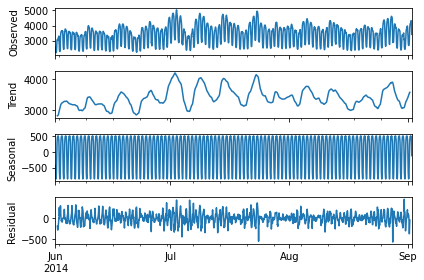

time: 933 ms (started: 2021-07-01 17:01:28 +00:00)


In [39]:
#taking load column:
data_load = data['load']
#Calling our function:
decomposition = sm.tsa.seasonal_decompose(data_load['2014-06-01':'2014-09-01'], model = 'additive')
#Plotting:
fig = decomposition.plot()
mpl.rcParams['figure.figsize'] = [14.0, 14.0]

we can see that the seasonality is following a consistent pattern while the trend is following an irregular
behaviour for the second half of year 2014. 

We can also plot the trend alongside the observed load variations together:

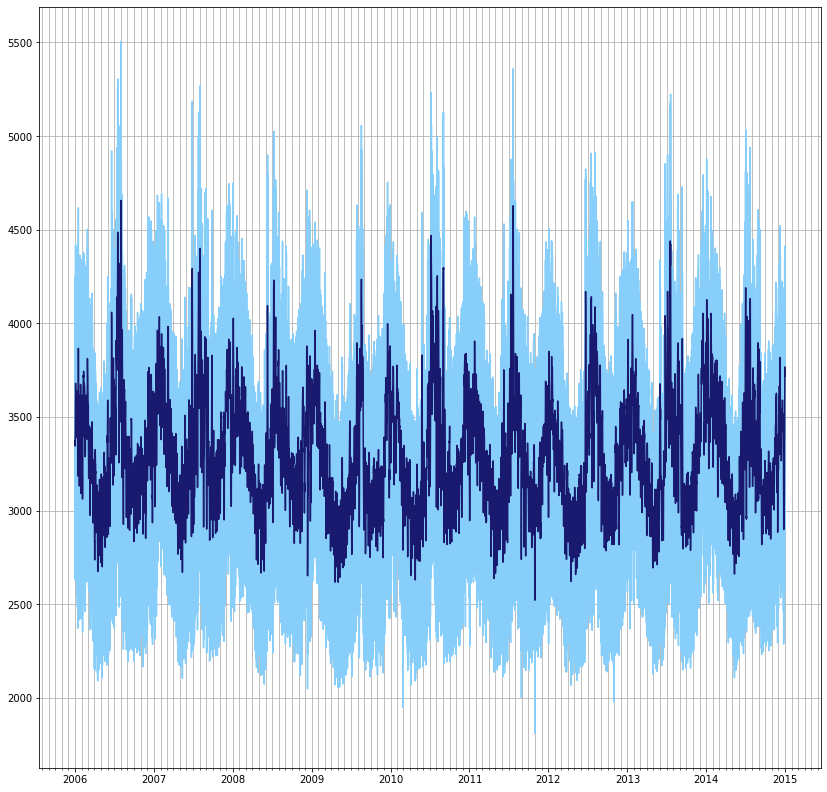

time: 1.77 s (started: 2021-07-01 17:01:29 +00:00)


In [40]:
#Calling function:
decomposition = sm.tsa.seasonal_decompose(data_load, model = 'additive')
#Plotting:
fig, ax = plt.subplots()
ax.grid(True)
#Matplotlib’s YearLocator() makes ticks on a given day of each year that is a multiple of base:
year = mdates.YearLocator(month=1)
month = mdates.MonthLocator(interval=1)
year_format = mdates.DateFormatter('%Y')
month_format = mdates.DateFormatter('%m')
ax.xaxis.set_minor_locator(month)
ax.xaxis.grid(True, which = 'minor')
ax.xaxis.set_major_locator(year)
ax.xaxis.set_major_formatter(year_format)
plt.plot(data_load.index, data_load, c=colors['lightskyblue'])
plt.plot(decomposition.trend.index, decomposition.trend, c=colors['midnightblue'])
mpl.rcParams['figure.figsize'] = [18.0, 6.0]

### Handling Missing Data

We have checked that the data has no missing elements, in neither load nor temperature. 

In general, missing values are represented in the time series by a sequence gap in the time stamp variable or in other values. If you have such a problem in your data, you
can fill missing values by interpolating between the two closest non-missing values via `dataframe.interpolate()`. However, you should note that only `method = 'linear'` is supported for DataFrames and series with a MultiIndex:

```
#you can interpolate linearly as follows:
data.interpolate(limit = 8, method ='linear', limit_direction ='both')
```

Note that if there is more than 8 missing data in both direction in time consecutively, the missing
values are not interpolated and they remain missing. This is set via `limit`. This is a precaution to limit the spurious interpolation.

You can also use `scipy.stats` package for more advanced options:

https://docs.scipy.org/doc/scipy/reference/tutorial/stats.html

### Normalization / Standardization in Time Series

Normalization rescales the data such that all values are within the range of 0 and 1. Standardization, on the other hand, rerescales the distribution of values so that
the mean values are 0 with a SD of 1. Similar to the previous exercises, we can use scikit learn for that purpose.

In [41]:
#Looking into the statistics:
data.describe()

,load,T
count,78888.000000,78888.000000
mean,3308.000837,47.573934
std,579.803021,19.201314
min,1811.000000,-18.000000
25%,2845.000000,32.670000
50%,3382.000000,48.670000
75%,3709.000000,63.000000
max,5506.000000,97.000000


time: 30.8 ms (started: 2021-07-01 17:01:31 +00:00)


In [42]:
#Rescaling the data
featuresToScale = data.columns
sX = pp.StandardScaler(copy=True)
data.loc[:,featuresToScale] = sX.fit_transform(data[featuresToScale])
#Looking into the statistics again:
data.describe()

,load,T
count,7.888800e+04,7.888800e+04
mean,-1.527668e-18,7.586890e-16
std,1.000006e+00,1.000006e+00
min,-2.581929e+00,-3.415097e+00
25%,-7.985536e-01,-7.761984e-01
50%,1.276289e-01,5.708323e-02
75%,6.916171e-01,8.033911e-01
max,3.790965e+00,2.574114e+00


time: 27.6 ms (started: 2021-07-01 17:01:31 +00:00)


In [43]:
data.loc[:,featuresToScale] = sX.inverse_transform(data[featuresToScale])
#Looking into the statistics again:
data.describe()

,load,T
count,78888.000000,78888.000000
mean,3308.000837,47.573934
std,579.803021,19.201314
min,1811.000000,-18.000000
25%,2845.000000,32.670000
50%,3382.000000,48.670000
75%,3709.000000,63.000000
max,5506.000000,97.000000


time: 23 ms (started: 2021-07-01 17:01:31 +00:00)


## Feature Engineering in Time Series

Feature engineering enables you to optimize the data fed into the ML algorithms so that the predictive accuracy of the model increased. In time series, there are some well-known tricks which helps to improve the model outcomes. Below you will find some illustrative examples for you to explore.

### Date - Time Features

Depending on the problem, you might see some patterns on sub-time items present in the time stamps; such as the hour, day, month etc. Imagine that you would like to capture the rush hour effects on utility consumption. In this case, it would be better to add this time information as an additional feature (column in dataframe). For that purpose, you can use `pandas` to add new columns (hour, month, and day of week columns) to your original dataset. In the ML algorithm, this new column will be taken into account as a new factor. 

Other important features might be:
+ Weekend or not
+ Business day or not
+ Public holiday or not
+ Quarter of the year
+ Before or after business hours
+ Season of the year

You can craft different filters according to your problem and your objective. 

In [44]:
data.head()

,load,T
2006-01-01 00:00:00,2985.0,24.33
2006-01-01 01:00:00,3010.0,22.67
2006-01-01 02:00:00,2853.0,20.67
2006-01-01 03:00:00,2758.0,21.33
2006-01-01 04:00:00,2705.0,19.00


time: 11.2 ms (started: 2021-07-01 17:01:31 +00:00)


In [45]:
#A simple example:
data['hour'] = [data.index[i].hour for i in range(len(data))]
data['month'] = [data.index[i].month for i in range(len(data))]
data['dayofWeek'] = [data.index[i].day for i in range(len(data))]
print(data.head(5))

                       load      T  hour  month  dayofWeek
2006-01-01 00:00:00  2985.0  24.33     0      1          1
2006-01-01 01:00:00  3010.0  22.67     1      1          1
2006-01-01 02:00:00  2853.0  20.67     2      1          1
2006-01-01 03:00:00  2758.0  21.33     3      1          1
2006-01-01 04:00:00  2705.0  19.00     4      1          1
time: 2.1 s (started: 2021-07-01 17:01:31 +00:00)


### Window Statistics as Feature

Another common trick is to introduce windows statistics as an additional feature. 

Sliding window method are a summary of values over a fixed window of prior timesteps. Here the basic idea is that you assume the past contain a sort of intrinsic information about the future that can be captured if you oberve the past in "windows".  A window of specified length is moved over the data, sample by sample, and the statistic of interest (mean, median etc) is computed over the data in these windows. For more, you may refer to:

https://www.geeksforgeeks.org/window-sliding-technique/

https://de.mathworks.com/help/dsp/ug/sliding-window-method-and-exponential-weighting-method.html

Here I will show you how to add "Rolling Window Statistics" as an additional feature to your data. 

In this method, you first define a rolling window of observations. Then, you use observations falling under this window to compute statistics of interest. Next, you roll over the next time step and repeat the same computation. You may consider it as an integral action over a given time interval.

`pandas` offers a `rolling()` function for that purpose, where it creates a new data structure with the window of values at each timestep:

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rolling.html

Here we will also a need the shifting in the time stamps. The shift method
uses a freq argument which can be a DateOffset class or a timedelta-like object or also an offset alias. 

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html

String aliases that are useful for common time series frequencies are listed here:

https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases

In [46]:
#How to add statistics features in dataframes:
#------------------------------------------------
#Lets use only the load data;
load_data = data[['load']]
#Defining the window width:
width = 4
#Shifting:if needed, use shifted with .rolling.
#shifted = load_data.shift(2)
#Calling Rolling:
window = load_data.rolling(window=width)
#Lets save as a new DF. We will add min, mean and max to the load column:
new_dataframe = pd.concat([window.min(),window.median(), window.max(), load_data], axis=1)
new_dataframe.columns = ['min', 'median', 'max', 'load']
print(new_dataframe.head(10))

                        min  median     max    load
2006-01-01 00:00:00     NaN     NaN     NaN  2985.0
2006-01-01 01:00:00     NaN     NaN     NaN  3010.0
2006-01-01 02:00:00     NaN     NaN     NaN  2853.0
2006-01-01 03:00:00  2758.0  2919.0  3010.0  2758.0
2006-01-01 04:00:00  2705.0  2805.5  3010.0  2705.0
2006-01-01 05:00:00  2705.0  2733.5  2853.0  2709.0
2006-01-01 06:00:00  2705.0  2731.0  2758.0  2753.0
2006-01-01 07:00:00  2705.0  2731.0  2849.0  2849.0
2006-01-01 08:00:00  2709.0  2801.0  3008.0  3008.0
2006-01-01 09:00:00  2753.0  2928.5  3243.0  3243.0
time: 42.3 ms (started: 2021-07-01 17:01:33 +00:00)


It is also possible to use Expanding Window Statistics in `pandas`, where all past is taken into account. It is done via `expanding() `function. Its use is very similar to rolling:

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.expanding.html

Feel free to test it by yourself!

# Some Basic Solutions for Time Series

This section is for you to explore. It is always to be aware of simple solutions, before jumping into more complex models. Speaking of which, I recommend to watch the following lecture on model simplicity:
[Winning with Simple, even Linear, Models](https://www.youtube.com/watch?v=68ABAU_V8qI). 

Linear statistical models (Autoregressive (AR) models, moving average (MA) models, and autoregressive integrated moving average (ARIMA) models) for time series have traditionally been the workhorses of time series forecasting, and they continue to be applied in a wide range of cases, from academic research to industry. This section will help you to have an idea on the subject. Note that these models are not built to handle nonlinear dynamics and will do a poor job describing data where nonlinear relationships are dominant.

## Autoregression

This is the simplest method: you assume that future depends on past linearly. 

In this model, one parameter is the "order", which defines the the number of previous input values in the time series that are used to predict the next step. Therefore, this is a hyperparameter to figure out for your data. 




### Autocorrelation

Because of this assumed linearity, autocorrelation becomes of significant importance here. It is a statistical property that occurs when a time series is linearly related to a previous time. 

In order to check whether there is a presence of autocorrelation in your data, you can use two different built-in plots of `pandas`: `lag_plot` and  `autocorrelation_plot`.  These functions can be imported from pandas.plotting:

https://pandas.pydata.org/docs/reference/api/pandas.plotting.lag_plot.html

https://pandas.pydata.org/docs/reference/api/pandas.plotting.autocorrelation_plot.html

Lag plots are most commonly used to look for patterns in time series data. For example, random data should not exhibit any patterns in the lag plot. Lets see our load data:

In [47]:
data.head()

,load,T,hour,month,dayofWeek
2006-01-01 00:00:00,2985.0,24.33,0,1,1
2006-01-01 01:00:00,3010.0,22.67,1,1,1
2006-01-01 02:00:00,2853.0,20.67,2,1,1
2006-01-01 03:00:00,2758.0,21.33,3,1,1
2006-01-01 04:00:00,2705.0,19.00,4,1,1


time: 14.7 ms (started: 2021-07-01 17:01:33 +00:00)


In [48]:
# Returning back to the original DF:
data = data.drop(['hour','month','dayofWeek'],axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 78888 entries, 2006-01-01 00:00:00 to 2014-12-31 23:00:00
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   load    78888 non-null  float64
 1   T       78888 non-null  float64
dtypes: float64(2)
memory usage: 4.3 MB
time: 12.7 ms (started: 2021-07-01 17:01:33 +00:00)


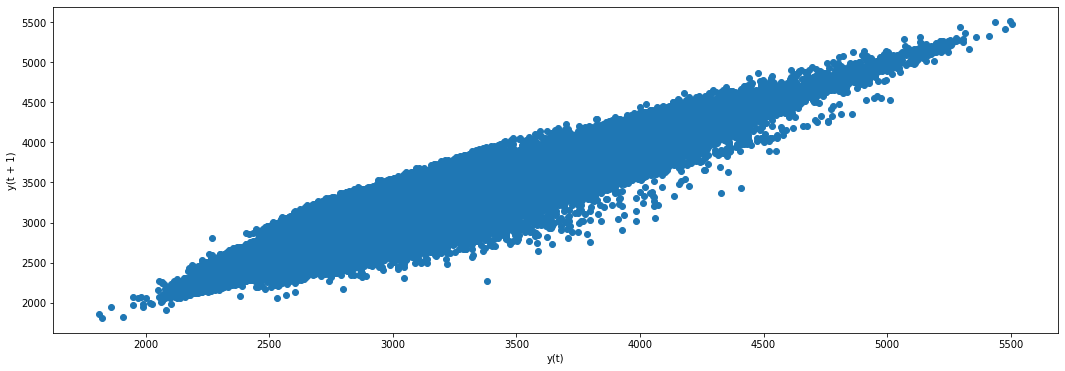

time: 442 ms (started: 2021-07-01 17:01:33 +00:00)


In [49]:
# Plotting the figure:
plt.figure()
lag_plot(data['load'])
mpl.rcParams['figure.figsize'] = [8.0, 8.0]

Here we see a clear relationship between the time steps t and t+1. 

Autocorrelation plots are also useful to check the randomness in time series. If time series is random, autocorrelation values should be near zero all the time. Otherwise, the autocorrelations will be significantly non-zero. 

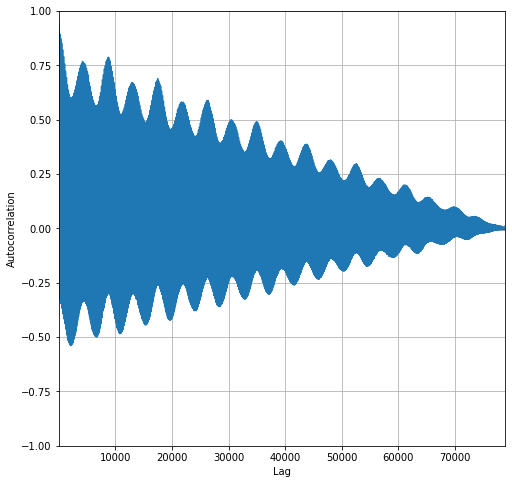

time: 10.3 s (started: 2021-07-01 17:01:34 +00:00)


In [50]:
#Checking autocorrelations:
plt.figure()
autocorrelation_plot(data['load'])
mpl.rcParams['figure.figsize'] = [8.0, 8.0]

Lets zoom in into a fraction of the data:

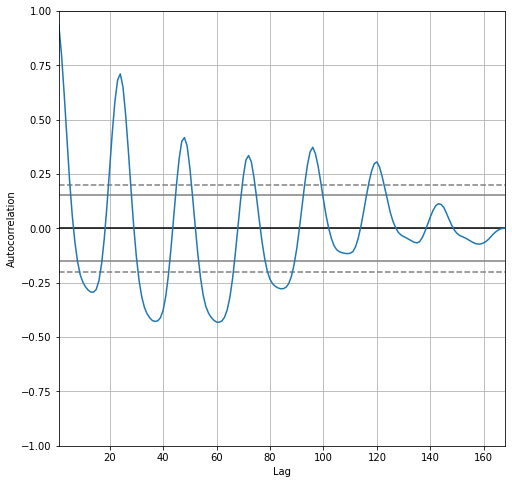

time: 237 ms (started: 2021-07-01 17:01:44 +00:00)


In [51]:
data_subset = data['load']['2014-01-01':'2014-01-07']
autocorrelation_plot(data_subset)
mpl.rcParams['figure.figsize'] = [12.0, 6.0]

Autocorrelation function ranges from –1 to 1. By default, the horizontal lines correspond to 95 percent  and the dashed line is 99 percent confidence band. Correlation values outside of this window are very likely a correlation. 

Plot tells us whether the data is positively correlated, negatively correlated, or independent of each other.

<Figure size 864x432 with 0 Axes>

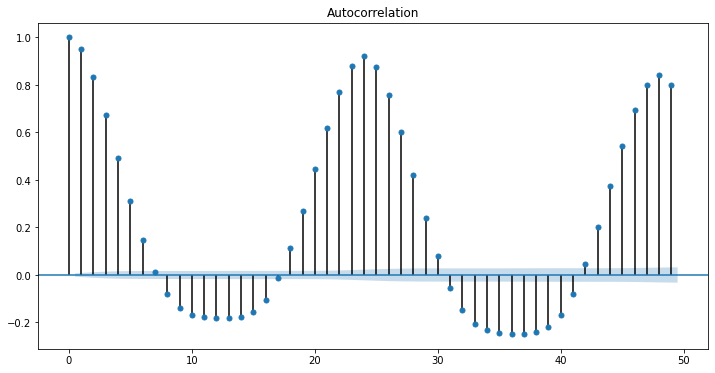

time: 1.87 s (started: 2021-07-01 17:01:44 +00:00)


In [52]:
#Another Library.
#Here confidence intervals are drawn as a cone:
plt.figure()
plot_acf(data['load']);

Another important concept to consider is partial correlation function (`pacf`). It is a function that measures the incremental benefit of adding another lag. Let's use it on our data:

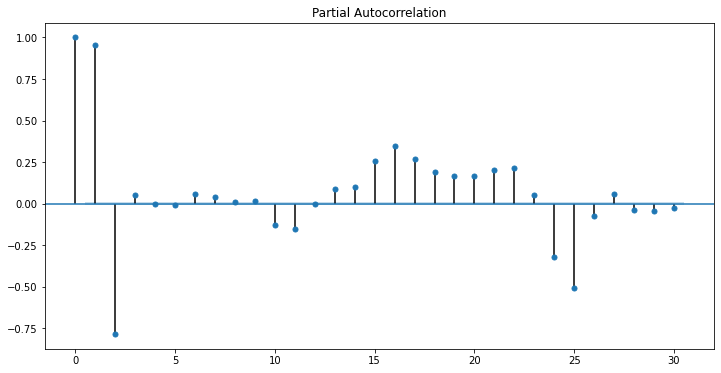

time: 294 ms (started: 2021-07-01 17:01:46 +00:00)


In [53]:
plot_pacf(data['load'], lags=30)
mpl.rcParams['figure.figsize'] = [12.0, 6.0]

Why do we need `acf` or `pacf`? We will use it to determine the
order of autoregressive and moving average time series methods. 

# Probabilistic learning with TF Probability

STS models are probability-based models combining familiar ideas in treating sequential data such as auto-regression, integration, moving averages, trends and seasonality (see our DDE 1 time series lecture for more details). Herein, the core idea is to express the model as a combination of "events" happening simultaneously:

$
f(t) = f_1 + f_2 + f_3 + ... f_n + \epsilon
$

Each function here represents a different dynamical system, summation of which yields the global behaviour (with an error). 

Bayesian structural time series (BSTS) are related to the linear Gaussian modelling we
saw in Kalman filtering. What is particularly useful about this approach is that the model gives posterior distribution, which in turn privde **both the forecasted value and  the model uncertainty.**

We will now implement the Structural Time Series (STS) [Module](https://www.tensorflow.org/probability/api_docs/python/tfp/sts) of TensorFlow Probability. The module includes Bayesian inference of model parameters using variational inference (VI) and Hamiltonian Monte Carlo (HMC), enabling us modeling time series in a probabilistic and/or stochastic way. 

## Data preparation

In [54]:
#Checking Data:
data.sample(3)

,load,T
2011-11-24 18:00:00,3134.0,34.33
2008-11-04 10:00:00,3536.0,46.33
2007-01-26 19:00:00,4618.0,1.67


time: 15.7 ms (started: 2021-07-01 17:01:46 +00:00)


In [55]:
#Rescaling the data
#featuresToScale = data.columns
#sX = pp.StandardScaler(copy=True)
#data.loc[:,featuresToScale] = sX.fit_transform(data[featuresToScale])
#Looking into the statistics again:
#data.describe()

time: 1.5 ms (started: 2021-07-01 17:01:46 +00:00)


In [56]:
# Train-Test Split:
# We will split the data as training and test. No need for validation here. 
train_start_dt = '2014-10-15'
test_start_dt = '2014-11-01'
test_end_dt = '2014-11-04'
# trainin data: filtered copy
train_data = data.copy()[(data.index >= train_start_dt)& (data.index < test_start_dt)][['load']]
# test data: filtered copy
test_data = data.copy()[(data.index >= test_start_dt) & (data.index < test_end_dt)][['load']]
#load data: 
load_data = data.copy()[(data.index >= train_start_dt) & (data.index < test_end_dt)][['load']]
#tempearture data:
temp_data = data.copy()[(data.index >= train_start_dt) & (data.index < test_end_dt)][['T']]
#lets see how it looks like:
print('Train data shape: ', train_data.shape)
print('Test data shape: ', test_data.shape)

Train data shape:  (408, 1)
Test data shape:  (72, 1)
time: 22.5 ms (started: 2021-07-01 17:01:46 +00:00)


In [57]:
#Checking Data:
train_data.sample(3)

,load
2014-10-29 09:00:00,3517.0
2014-10-20 23:00:00,2932.0
2014-10-29 23:00:00,2915.0


time: 9.31 ms (started: 2021-07-01 17:01:47 +00:00)


## Defining structural components

Here the load data is our primary concern, while the temperature data is an external source of information, which we believe to be related to the load demand. So we will pass temperature information as an additional relationship. 

Now lets create subfunctions $f_i$ to define strcutural components. We will start with seasonal trends. 

In [58]:
# train:
train = train_data['load'].to_numpy()
print(train.shape)

(408,)
time: 3.79 ms (started: 2021-07-01 17:01:47 +00:00)


In [59]:
#temperature:
Temp = temp_data['T'].to_numpy()
print(Temp.shape)

(480,)
time: 2.32 ms (started: 2021-07-01 17:01:47 +00:00)


### Seasonal information:

In [60]:
# here we use our imagination! What kind of seasonality do we expect? 
# lets define three basic seasonality:
#https://www.tensorflow.org/probability/api_docs/python/tfp/sts/Seasonal
#note:
#----------------------------------------------------------------------------------------
#The drift_scale parameter governs the standard deviation of the random walk; 
#for example, in a day-of-week model it governs the change in effect from this Monday 
#to next Monday.
#----------------------------------------------------------------------------------------
#Seasonal effect 1: daily cycle:
day_of_week = tfp.sts.Seasonal(
    num_seasons=7,
    num_steps_per_season=24,
    observed_time_series=train,
    name='day_of_week')
#Seasonal effect 2: weekly cycle:
weekly_cycle = tfp.sts.Seasonal(
    num_seasons=52, # 52 weeks in year
    observed_time_series=train,
    allow_drift=True,
    #-----------------------------------------------------------
    #manual definition: see above link...
    #drift_scale_prior=tfd.Normal(loc=1., scale=0.1), 
    #initial_effect_prior=tfd.Normal(loc=0., scale=5.),
    #-----------------------------------------------------------
    name='weekly_effect')
# Seasonal effect 3: monthly cycle of the year:
monthly_cycle = tfp.sts.Seasonal(
    num_seasons=12, # 12 months in year
    num_steps_per_season=4, # further granularity; assumed 4 weeks in every month
    observed_time_series=train,
    name='month_of_year_effect')

Instructions for updating:
Do not call `graph_parents`.
Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.
time: 5.69 s (started: 2021-07-01 17:01:47 +00:00)


### Trend information:

When we look at the data decompostion, it seems that our trend is not that simple! Therefore, it is difficult to estimate a behaviour like a linear relationship:

```
# Linear trend is assumed:
trend = tfp.sts.LocalLinearTrend(
    observed_time_series=train,
    name='trend')
```

Therefore we need an alternative. What do we know about the general trends in time series data? 

We can say series have inherent temporal structure; that is,  sequential observations are dependent on the previous n observations in time i.e. autocorrelation. If we assume such a relationship, we can use `SemiLocalLinearTrend` model. In thes model, the slope evolves according to a first-order autoregressive process:

https://www.tensorflow.org/probability/api_docs/python/tfp/sts/SemiLocalLinearTrend

```
tfp.sts.SemiLocalLinearTrend(
    level_scale_prior=None, slope_mean_prior=None, slope_scale_prior=None,
    autoregressive_coef_prior=None, initial_level_prior=None,
    initial_slope_prior=None, observed_time_series=None,
    constrain_ar_coef_stationary=True, constrain_ar_coef_positive=False, name=None
)


```
The semi-local linear trend model is a special case of a linear Gaussian SSM, in which the latent state posits a level and slope. The level evolves via a Gaussian random walk centered at the current slope, while the slope follows a first-order autoregressive (AR1) process with mean slope_mean.

The latent state is the two-dimensional tuple [level, slope]. The level is observed at each timestep.



In [61]:
trend = tfp.sts.SemiLocalLinearTrend(
            observed_time_series=train,
            constrain_ar_coef_stationary=True, 
            name='trend')

time: 16.6 ms (started: 2021-07-01 17:01:52 +00:00)


### Residual information:

In the decomposed data, we saw that the residuals in the load data is relatively stationary; therefore, the residual behaviour can be represented by a stationary model, `AutoRegressive`:

https://www.tensorflow.org/probability/api_docs/python/tfp/sts/Autoregressive

```
tfp.sts.Autoregressive(
    order, coefficients_prior=None, level_scale_prior=None,
    initial_state_prior=None, coefficient_constraining_bijector=None,
    observed_time_series=None, name=None
)

```


In [62]:
residuals = tfp.sts.Autoregressive(
    order=1,
    observed_time_series=train,
    coefficients_prior=None,
    level_scale_prior=None,
    initial_state_prior=None,
    name='residuals_autoregressive')

time: 31.9 ms (started: 2021-07-01 17:01:52 +00:00)


### Temperature information:

In [63]:
#https://www.tensorflow.org/probability/api_docs/python/tfp/sts/LinearRegression
#design_matrix: float Tensor of shape concat([batch_shape, [num_timesteps, num_features]])
temperature_effect = sts.LinearRegression(
      design_matrix=tf.reshape(Temp - np.mean(Temp),
                               (-1, 1)), name='temperature_effect')

time: 8.1 ms (started: 2021-07-01 17:01:52 +00:00)


## Defining the model

Now we have all $f_i$ and can define the structural time series model $f$ by using the `tfp.sts.Sum` class: 

```
tfp.sts.Sum(
    components, constant_offset=None, observation_noise_scale_prior=None,
    observed_time_series=None, name=None
)
```



In [64]:
def build_model(observed_time_series):
  model = sts.Sum([day_of_week,weekly_cycle,residuals,temperature_effect],
                   observed_time_series=observed_time_series)
  return model

time: 1.18 ms (started: 2021-07-01 17:01:52 +00:00)


In [65]:
load_model = build_model(train)

time: 7.1 ms (started: 2021-07-01 17:01:52 +00:00)


## Model training

Our model is now ready. The next step is the training, during which our model will learn a probability distribution, that is, how the posterior evolves in time.

Here we have options.  First, we'll fit the model with **variational inference (VI)** and draw samples from the posterior. 

VI fits a set of approximate posterior distributions for the model parameters(for each $f_i$) and optimises these by minimising a variational loss function known as negative Evidence Lower Bound (ELBO).

See also:

https://en.wikipedia.org/wiki/Variational_Bayesian_methods

https://en.wikipedia.org/wiki/Evidence_lower_bound

https://www.youtube.com/watch?v=HxQ94L8n0vU



In [66]:
# Building the variational surrogate posteriors `qs`:
#https://www.tensorflow.org/probability/api_docs/python/tfp/sts/build_factored_surrogate_posterior
variational_posteriors = tfp.sts.build_factored_surrogate_posterior(
    model=load_model)

time: 485 ms (started: 2021-07-01 17:01:52 +00:00)


In [67]:
## on tf.function:
## It accepts a function, in this instance our STS model, as an argument 
## and compiles it into a callable TensorFlow graph:
#https://www.tensorflow.org/api_docs/python/tf/function
#https://www.tensorflow.org/guide/intro_to_graphs

time: 1.37 ms (started: 2021-07-01 17:01:53 +00:00)


In [68]:
num_variational_steps = 120 
optimizer = tf.optimizers.Adam(learning_rate=.1)
# Using fit_surrogate_posterior to build and optimize the variational loss function:
@tf.function(jit_compile=True)
def train_sts_model():
  #Model used: VI
  #https://www.tensorflow.org/probability/api_docs/python/tfp/vi
  #https://www.tensorflow.org/probability/api_docs/python/tfp/vi/fit_surrogate_posterior
  #constructs and minimizes the negative variational evidence lower bound (ELBO)...
  elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn=load_model.joint_log_prob(
        observed_time_series=train),
    surrogate_posterior=variational_posteriors,
    optimizer=optimizer,
    num_steps=num_variational_steps)
  return elbo_loss_curve

elbo_loss_curve = train_sts_model()

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
time: 1min 6s (started: 2021-07-01 17:01:53 +00:00)


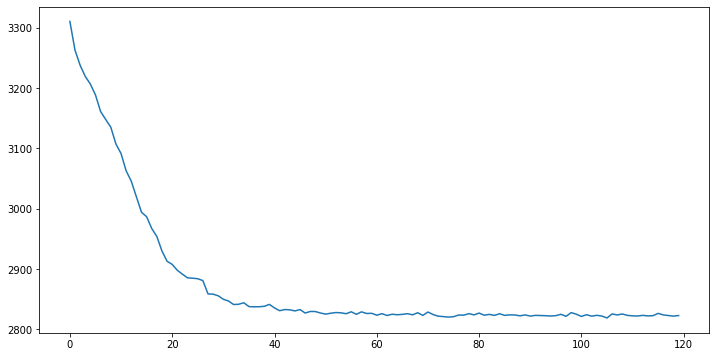

time: 138 ms (started: 2021-07-01 17:02:59 +00:00)


In [69]:
# Plot KL divergence
plt.plot(elbo_loss_curve)
plt.show()

In [70]:
# Draw samples from the variational posterior.
q_samples_demand_ = variational_posteriors.sample(10)

time: 38.4 ms (started: 2021-07-01 17:02:59 +00:00)


In [71]:
print("Inferred parameters:")
for param in load_model.parameters:
  print("{}: {} +- {}".format(param.name,
                              np.mean(q_samples_demand_[param.name], axis=0),
                              np.std(q_samples_demand_[param.name], axis=0)))

Inferred parameters:
observation_noise_scale: 8.419843407904686 +- 13.45047803646093
day_of_week/_drift_scale: 6.387478122403776 +- 12.943810442653986
weekly_effect/_drift_scale: 6.148164437151246 +- 4.9599042169615135
residuals_autoregressive/_coefficients: [0.92689265] +- [0.01691234]
residuals_autoregressive/_level_scale: 174.16308685054028 +- 3.5141552986990416
temperature_effect/_weights: [1.26406468] +- [3.56555638]
time: 8.93 ms (started: 2021-07-01 17:02:59 +00:00)


## Forecasting

After ensuring the convergence of the loss function, we can continue with the forecasting. 

This is done by drawing traces (i.e. samples) from the variational posterior and passing these as an argument to `tfp.sts.forecast()`:

```
tfp.sts.forecast(
    model, observed_time_series, parameter_samples, num_steps_forecast,
    include_observation_noise=True
)
```

It returns the predictive distribution over the future observations for the desired number of steps; `num_steps_forecast`.

In [72]:
# test:
test = test_data['load'].to_numpy()
print(test.shape[0])

72
time: 2.57 ms (started: 2021-07-01 17:02:59 +00:00)


In [73]:
traces__ = variational_posteriors.sample(10)
n_forecast_steps = test.shape[0]

time: 38.6 ms (started: 2021-07-01 17:02:59 +00:00)


In [74]:
demand_forecast_dist = tfp.sts.forecast(
    model=load_model,
    observed_time_series=train,
    parameter_samples=traces__,
    num_steps_forecast=n_forecast_steps)

time: 15 s (started: 2021-07-01 17:02:59 +00:00)


In [75]:
# Draw samples:
#-----------------------------------------------------------------------------------------------
# the mean and stddev of the forecast distribution give us a prediction with 
# marginal uncertainty at each timestep, and we can also draw samples of possible futures.
#-----------------------------------------------------------------------------------------------
num_samples=10 # Assign vars corresponding to variational posterior

demand_forecast_mean,demand_forecast_scale,demand_forecast_samples = (
    demand_forecast_dist.mean().numpy()[..., 0],
    demand_forecast_dist.stddev().numpy()[..., 0],
    demand_forecast_dist.sample(num_samples).numpy()[..., 0]
    )

time: 8.49 s (started: 2021-07-01 17:03:14 +00:00)


In [76]:
def plot_forecast(x, y,
                  forecast_mean, forecast_scale, forecast_samples,
                  title, x_locator=None, x_formatter=None):
  """Plot a forecast distribution against the 'true' time series."""
  colors = sns.color_palette()
  c1, c2 = colors[0], colors[1]
  fig = plt.figure(figsize=(12, 6))
  ax = fig.add_subplot(1, 1, 1)

  num_steps = len(y)
  num_steps_forecast = forecast_mean.shape[-1]
  num_steps_train = num_steps - num_steps_forecast


  ax.plot(x, y, lw=2, color=c1, label='ground truth')

  forecast_steps = np.arange(
      x[num_steps_train],
      x[num_steps_train]+num_steps_forecast,
      dtype=x.dtype)

  ax.plot(forecast_steps, forecast_samples.T, lw=1, color=c2, alpha=0.1)

  ax.plot(forecast_steps, forecast_mean, lw=2, ls='--', color=c2,
           label='forecast')
  ax.fill_between(forecast_steps,
                   forecast_mean-2*forecast_scale,
                   forecast_mean+2*forecast_scale, color=c2, alpha=0.2)

  ymin, ymax = min(np.min(forecast_samples), np.min(y)), max(np.max(forecast_samples), np.max(y))
  yrange = ymax-ymin
  ax.set_ylim([ymin - yrange*0.1, ymax + yrange*0.1])
  ax.set_title("{}".format(title))
  ax.legend()

  if x_locator is not None:
    ax.xaxis.set_major_locator(x_locator)
    ax.xaxis.set_major_formatter(x_formatter)
    fig.autofmt_xdate()

  return fig, ax

time: 22.7 ms (started: 2021-07-01 17:03:23 +00:00)


In [77]:
# load data:
load_true = load_data['load'].to_numpy()
print(load_true.shape[0])

480
time: 1.26 ms (started: 2021-07-01 17:03:23 +00:00)


In [78]:
dates = load_data.copy().reset_index()['index']
dates = dates.values.astype('datetime64[h]')
dates[:3]

array(['2014-10-15T00', '2014-10-15T01', '2014-10-15T02'],
      dtype='datetime64[h]')

time: 12.9 ms (started: 2021-07-01 17:03:23 +00:00)


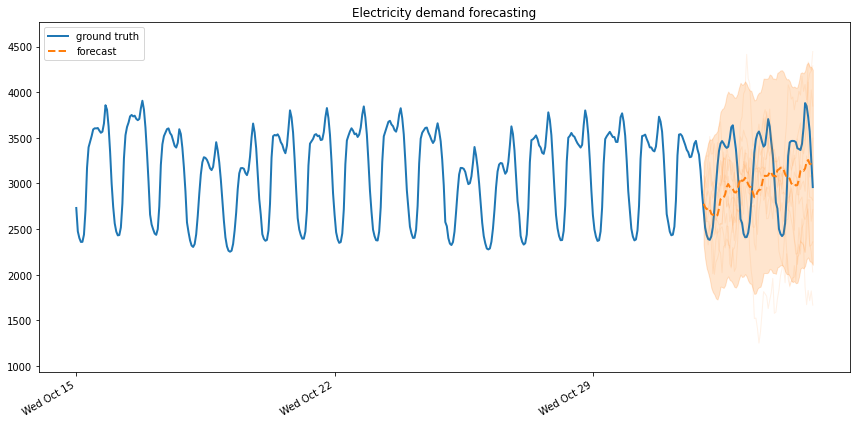

time: 299 ms (started: 2021-07-01 17:03:23 +00:00)


In [79]:
demand_loc = mdates.WeekdayLocator(byweekday=mdates.WE)
demand_fmt = mdates.DateFormatter('%a %b %d')

fig, ax = plot_forecast(dates, load_true,
                        demand_forecast_mean,
                        demand_forecast_scale,
                        demand_forecast_samples,
                        title="Electricity demand forecasting",
                        x_locator=demand_loc, x_formatter=demand_fmt)
fig.tight_layout()

In [80]:
# Remember to check for div by zero errors first
print(np.mean(np.abs((test- demand_forecast_mean) / test)) * 100)

13.880766293215189
time: 2.01 ms (started: 2021-07-01 17:03:23 +00:00)


Let's visualize the decomposition of the observed and forecast series into the individual components:

In [81]:
# Get the distributions over component outputs from the posterior marginals on
# training data:
component_dists = sts.decompose_by_component(
    load_model,
    observed_time_series=train,
    parameter_samples=q_samples_demand_)


time: 16.8 s (started: 2021-07-01 17:03:23 +00:00)


In [82]:
forecast_component_dists = sts.decompose_forecast_by_component(
    load_model,
    forecast_dist=demand_forecast_dist,
    parameter_samples=q_samples_demand_)

time: 4.61 s (started: 2021-07-01 17:03:40 +00:00)


In [83]:
demand_component_means_, demand_component_stddevs_ = (
    {k.name: c.mean() for k, c in component_dists.items()},
    {k.name: c.stddev() for k, c in component_dists.items()})

(
    demand_forecast_component_means_,
    demand_forecast_component_stddevs_
) = (
    {k.name: c.mean() for k, c in forecast_component_dists.items()},
    {k.name: c.stddev() for k, c in forecast_component_dists.items()}
    )

time: 29.1 ms (started: 2021-07-01 17:03:45 +00:00)


In [84]:
# Concatenate the training data with forecasts for plotting.
component_with_forecast_means_ = collections.OrderedDict()
component_with_forecast_stddevs_ = collections.OrderedDict()
for k in demand_component_means_.keys():
  component_with_forecast_means_[k] = np.concatenate([
      demand_component_means_[k],
      demand_forecast_component_means_[k]], axis=-1)
  component_with_forecast_stddevs_[k] = np.concatenate([
      demand_component_stddevs_[k],
      demand_forecast_component_stddevs_[k]], axis=-1)

time: 6.15 ms (started: 2021-07-01 17:03:45 +00:00)


In [85]:
def plot_components(dates,
                    component_means_dict,
                    component_stddevs_dict,
                    x_locator=None,
                    x_formatter=None):
  """Plot the contributions of posterior components in a single figure."""
  colors = sns.color_palette()
  c1, c2 = colors[0], colors[1]

  axes_dict = collections.OrderedDict()
  num_components = len(component_means_dict)
  fig = plt.figure(figsize=(12, 2.5 * num_components))
  for i, component_name in enumerate(component_means_dict.keys()):
    component_mean = component_means_dict[component_name]
    component_stddev = component_stddevs_dict[component_name]

    ax = fig.add_subplot(num_components,1,1+i)
    ax.plot(dates, component_mean, lw=2)
    ax.fill_between(dates,
                     component_mean-2*component_stddev,
                     component_mean+2*component_stddev,
                     color=c2, alpha=0.5)
    ax.set_title(component_name)
    if x_locator is not None:
      ax.xaxis.set_major_locator(x_locator)
      ax.xaxis.set_major_formatter(x_formatter)
    axes_dict[component_name] = ax
  fig.autofmt_xdate()
  fig.tight_layout()
  return fig, axes_dict

time: 14.7 ms (started: 2021-07-01 17:03:45 +00:00)


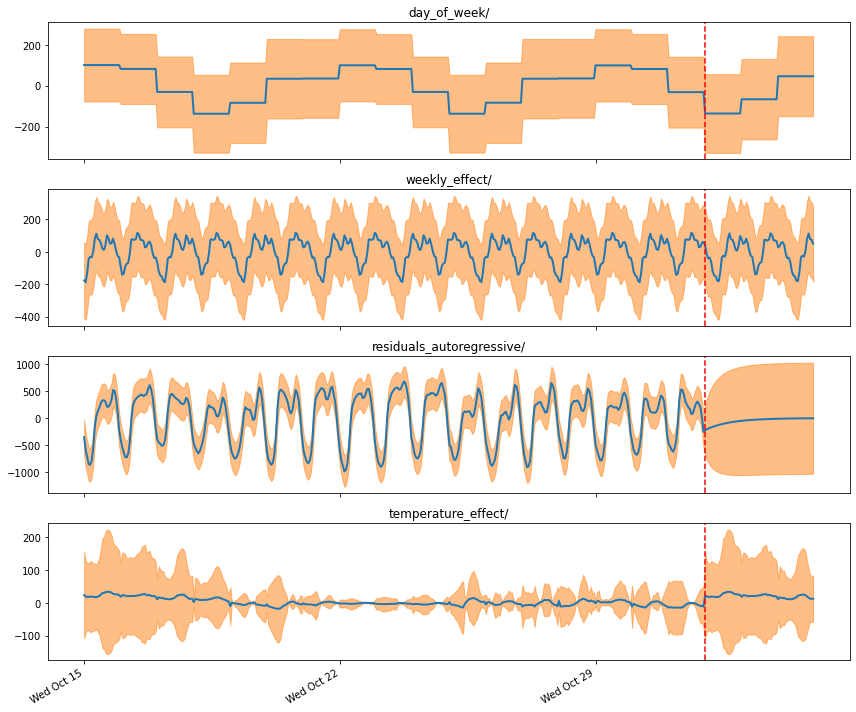

time: 777 ms (started: 2021-07-01 17:03:45 +00:00)


In [86]:
fig, axes = plot_components(
  dates,
  component_with_forecast_means_,
  component_with_forecast_stddevs_,
  x_locator=demand_loc, x_formatter=demand_fmt)
for ax in axes.values():
  ax.axvline(dates[-n_forecast_steps], linestyle="--", color='red')

## Lets try it again...

In [142]:
#Checking Data:
train_data.sample(3)

,load
2012-04-27 14:00:00,3306.0
2012-04-28 02:00:00,2377.0
2012-04-21 22:00:00,2953.0


time: 11.4 ms (started: 2021-07-01 18:57:18 +00:00)


In [143]:
# Train-Test Split:
# We will split the data as training and test. No need for validation here. 
train_start_dt = '2012-04-08'
test_start_dt = '2012-05-01'
test_end_dt = '2012-05-04'
# trainin data: filtered copy
train_data = data.copy()[(data.index >= train_start_dt)& (data.index < test_start_dt)][['load']]
# test data: filtered copy
test_data = data.copy()[(data.index >= test_start_dt) & (data.index < test_end_dt)][['load']]
#load data: 
load_data = data.copy()[(data.index >= train_start_dt) & (data.index < test_end_dt)][['load']]
#tempearture data:
temp_data = data.copy()[(data.index >= train_start_dt) & (data.index < test_end_dt)][['T']]
#lets see how it looks like:
print('Train data shape: ', train_data.shape)
print('Test data shape: ', test_data.shape)

Train data shape:  (552, 1)
Test data shape:  (72, 1)
time: 17.2 ms (started: 2021-07-01 18:57:20 +00:00)


In [144]:
# train:
train = train_data['load'].to_numpy()
print(train.shape)

(552,)
time: 2.01 ms (started: 2021-07-01 18:57:22 +00:00)


In [145]:
#temperature:
Temp = temp_data['T'].to_numpy()
print(Temp.shape)

(624,)
time: 1.69 ms (started: 2021-07-01 18:57:23 +00:00)


In [146]:
# here we use our imagination! What kind of seasonality do we expect? 
# lets define three basic seasonality:
#https://www.tensorflow.org/probability/api_docs/python/tfp/sts/Seasonal
#note:
#----------------------------------------------------------------------------------------
#The drift_scale parameter governs the standard deviation of the random walk; 
#for example, in a day-of-week model it governs the change in effect from this Monday 
#to next Monday.
#----------------------------------------------------------------------------------------
hour_of_day_effect = sts.Seasonal(
      num_seasons=24,
      observed_time_series=train,
      name='hour_of_day_effect')
day_of_week_effect = sts.Seasonal(
      num_seasons=7, num_steps_per_season=24,
      observed_time_series=train,
      name='day_of_week_effect')

time: 46.4 ms (started: 2021-07-01 18:57:25 +00:00)


In [147]:
#https://www.tensorflow.org/probability/api_docs/python/tfp/sts/LinearRegression
#design_matrix: float Tensor of shape concat([batch_shape, [num_timesteps, num_features]])
temperature_effect = sts.LinearRegression(
      design_matrix=tf.reshape(Temp - np.mean(Temp),
                               (-1, 1)), name='temperature_effect')

time: 8.46 ms (started: 2021-07-01 18:57:27 +00:00)


In [148]:
def build_model(observed_time_series):
  model = sts.Sum([hour_of_day_effect,day_of_week_effect,temperature_effect],
                   observed_time_series=observed_time_series)
  return model

time: 1.52 ms (started: 2021-07-01 18:57:27 +00:00)


In [149]:
load_model = build_model(train)

time: 10.8 ms (started: 2021-07-01 18:57:29 +00:00)


In [150]:
# Building the variational surrogate posteriors `qs`:
#https://www.tensorflow.org/probability/api_docs/python/tfp/sts/build_factored_surrogate_posterior
variational_posteriors = tfp.sts.build_factored_surrogate_posterior(
    model=load_model)

time: 138 ms (started: 2021-07-01 18:57:31 +00:00)


In [151]:
## on tf.function:
## It accepts a function, in this instance our STS model, as an argument 
## and compiles it into a callable TensorFlow graph:
#https://www.tensorflow.org/api_docs/python/tf/function
#https://www.tensorflow.org/guide/intro_to_graphs

time: 985 µs (started: 2021-07-01 18:57:33 +00:00)


In [152]:
num_variational_steps = 120 
optimizer = tf.optimizers.Adam(learning_rate=.1)
# Using fit_surrogate_posterior to build and optimize the variational loss function:
@tf.function(jit_compile=True)
def train_sts_model():
  #Model used: VI
  #https://www.tensorflow.org/probability/api_docs/python/tfp/vi
  #https://www.tensorflow.org/probability/api_docs/python/tfp/vi/fit_surrogate_posterior
  #constructs and minimizes the negative variational evidence lower bound (ELBO)...
  elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn=load_model.joint_log_prob(
        observed_time_series=train),
    surrogate_posterior=variational_posteriors,
    optimizer=optimizer,
    num_steps=num_variational_steps)
  return elbo_loss_curve

elbo_loss_curve = train_sts_model()

time: 59 s (started: 2021-07-01 18:57:34 +00:00)


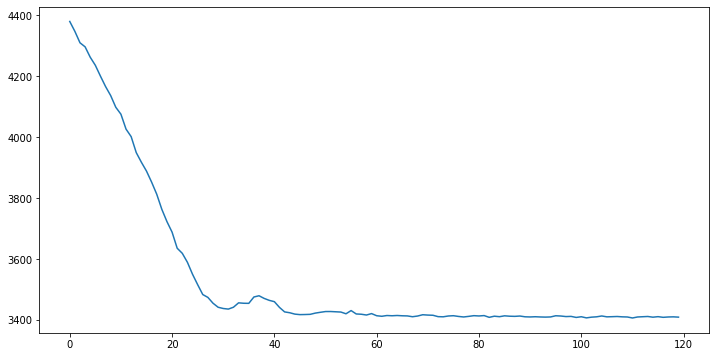

time: 143 ms (started: 2021-07-01 18:58:33 +00:00)


In [153]:
# Plot KL divergence
plt.plot(elbo_loss_curve)
plt.show()

In [154]:
# Draw samples from the variational posterior.
q_samples_demand_ = variational_posteriors.sample(10)

time: 24 ms (started: 2021-07-01 18:58:33 +00:00)


In [155]:
print("Inferred parameters:")
for param in load_model.parameters:
  print("{}: {} +- {}".format(param.name,
                              np.mean(q_samples_demand_[param.name], axis=0),
                              np.std(q_samples_demand_[param.name], axis=0)))

Inferred parameters:
observation_noise_scale: 91.23711095747507 +- 3.4531200863006726
hour_of_day_effect/_drift_scale: 7.664559637756423 +- 2.2994479828973735
day_of_week_effect/_drift_scale: 42.017860655040735 +- 5.924680787704255
temperature_effect/_weights: [-3.57256361] +- [0.51903294]
time: 7.81 ms (started: 2021-07-01 18:58:34 +00:00)


In [156]:
# test:
test = test_data['load'].to_numpy()
print(test.shape[0])

72
time: 2.61 ms (started: 2021-07-01 18:58:34 +00:00)


In [157]:
traces__ = variational_posteriors.sample(10)
n_forecast_steps = test.shape[0]

time: 31.7 ms (started: 2021-07-01 18:58:34 +00:00)


In [158]:
demand_forecast_dist = tfp.sts.forecast(
    model=load_model,
    observed_time_series=train,
    parameter_samples=traces__,
    num_steps_forecast=n_forecast_steps)

time: 18.2 s (started: 2021-07-01 18:58:34 +00:00)


In [159]:
# Draw samples:
#-----------------------------------------------------------------------------------------------
# the mean and stddev of the forecast distribution give us a prediction with 
# marginal uncertainty at each timestep, and we can also draw samples of possible futures.
#-----------------------------------------------------------------------------------------------
num_samples=10 # Assign vars corresponding to variational posterior

demand_forecast_mean,demand_forecast_scale,demand_forecast_samples = (
    demand_forecast_dist.mean().numpy()[..., 0],
    demand_forecast_dist.stddev().numpy()[..., 0],
    demand_forecast_dist.sample(num_samples).numpy()[..., 0]
    )

time: 7.95 s (started: 2021-07-01 18:58:52 +00:00)


In [160]:
# load data:
load_true = load_data['load'].to_numpy()
print(load_true.shape[0])

624
time: 2.35 ms (started: 2021-07-01 19:04:16 +00:00)


In [161]:
dates = load_data.copy().reset_index()['index']
dates = dates.values.astype('datetime64[h]')
dates[:3]

array(['2012-04-08T00', '2012-04-08T01', '2012-04-08T02'],
      dtype='datetime64[h]')

time: 7.66 ms (started: 2021-07-01 19:04:17 +00:00)


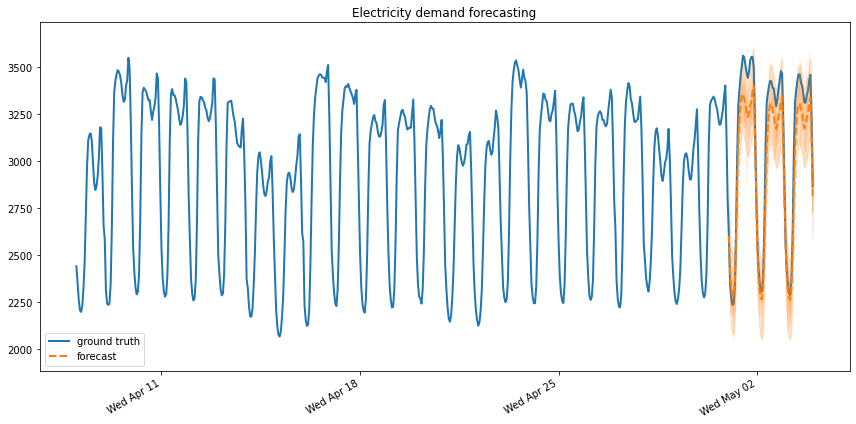

time: 325 ms (started: 2021-07-01 19:04:18 +00:00)


In [162]:
demand_loc = mdates.WeekdayLocator(byweekday=mdates.WE)
demand_fmt = mdates.DateFormatter('%a %b %d')

fig, ax = plot_forecast(dates, load_true,
                        demand_forecast_mean,
                        demand_forecast_scale,
                        demand_forecast_samples,
                        title="Electricity demand forecasting",
                        x_locator=demand_loc, x_formatter=demand_fmt)
fig.tight_layout()

In [108]:
# Remember to check for div by zero errors first
print(np.mean(np.abs((test- demand_forecast_mean) / test)) * 100)

3.7970398007198285
time: 1.35 ms (started: 2021-07-01 17:05:12 +00:00)


In [109]:
# Get the distributions over component outputs from the posterior marginals on
# training data:
component_dists = sts.decompose_by_component(
    load_model,
    observed_time_series=train,
    parameter_samples=q_samples_demand_)


time: 20 s (started: 2021-07-01 17:05:12 +00:00)


In [110]:
forecast_component_dists = sts.decompose_forecast_by_component(
    load_model,
    forecast_dist=demand_forecast_dist,
    parameter_samples=q_samples_demand_)

time: 4.09 s (started: 2021-07-01 17:05:32 +00:00)


In [111]:
demand_component_means_, demand_component_stddevs_ = (
    {k.name: c.mean() for k, c in component_dists.items()},
    {k.name: c.stddev() for k, c in component_dists.items()})

(
    demand_forecast_component_means_,
    demand_forecast_component_stddevs_
) = (
    {k.name: c.mean() for k, c in forecast_component_dists.items()},
    {k.name: c.stddev() for k, c in forecast_component_dists.items()}
    )

time: 25.2 ms (started: 2021-07-01 17:05:36 +00:00)


In [112]:
# Concatenate the training data with forecasts for plotting.
component_with_forecast_means_ = collections.OrderedDict()
component_with_forecast_stddevs_ = collections.OrderedDict()
for k in demand_component_means_.keys():
  component_with_forecast_means_[k] = np.concatenate([
      demand_component_means_[k],
      demand_forecast_component_means_[k]], axis=-1)
  component_with_forecast_stddevs_[k] = np.concatenate([
      demand_component_stddevs_[k],
      demand_forecast_component_stddevs_[k]], axis=-1)

time: 5.1 ms (started: 2021-07-01 17:05:36 +00:00)


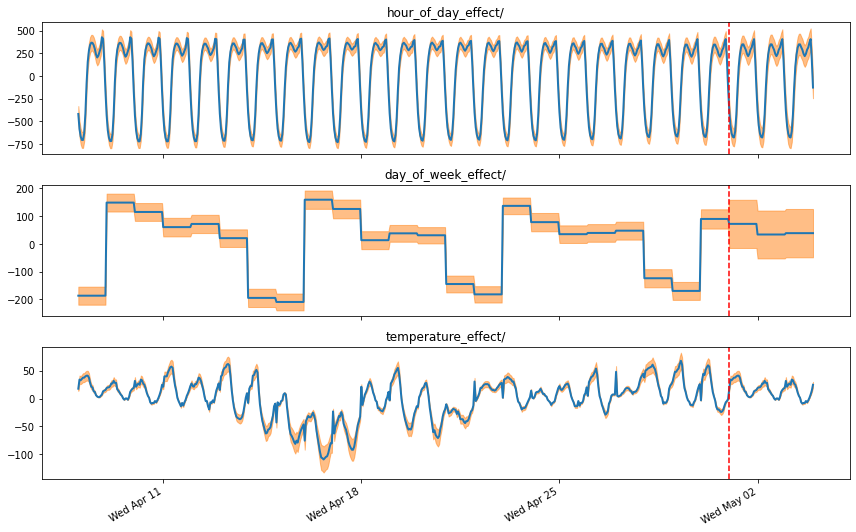

time: 600 ms (started: 2021-07-01 17:05:36 +00:00)


In [113]:
fig, axes = plot_components(
  dates,
  component_with_forecast_means_,
  component_with_forecast_stddevs_,
  x_locator=demand_loc, x_formatter=demand_fmt)
for ax in axes.values():
  ax.axvline(dates[-n_forecast_steps], linestyle="--", color='red')

## Alternative way for forecasting: MCMC

Markov chain Monte Carlo (MCMC) methods are considered the gold standard of Bayesian inference; under suitable conditions and in the limit of infinitely many draws they generate samples from the true posterior distribution. 

Hamiltonian Monte Carlo (HMC) uses gradients of the model's log-density function to propose samples, allowing it to exploit posterior geometry. However, it is computationally more expensive than variational inference and relatively sensitive to tuning.

https://www.tensorflow.org/probability/api_docs/python/tfp/sts/fit_with_hmc

In [114]:
def build_model(observed_time_series):
  model = sts.Sum([hour_of_day_effect,day_of_week_effect,temperature_effect],
                   observed_time_series=observed_time_series)
  return model

time: 2.1 ms (started: 2021-07-01 17:05:37 +00:00)


In [115]:
load_model = build_model(train)
samples, kernel_results = tfp.sts.fit_with_hmc(load_model, train, chain_batch_shape=[10])


/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/mcmc/sample.py:341: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


time: 1h 27min 56s (started: 2021-07-01 17:05:37 +00:00)


In [116]:
# test:
test = test_data['load'].to_numpy()
print(test.shape[0])
n_forecast_steps = test.shape[0]

72
time: 2.64 ms (started: 2021-07-01 18:33:34 +00:00)


In [118]:
forecast_dist = tfp.sts.forecast(load_model, train,
                                  parameter_samples=samples,
                                  num_steps_forecast=n_forecast_steps)


time: 18 s (started: 2021-07-01 18:37:57 +00:00)


In [163]:
num_samples=10 # Assign vars corresponding to variational posterior
demand_forecast_mean = forecast_dist.mean()[..., 0]  # shape: [72]
demand_forecast_scale = forecast_dist.stddev()[..., 0]  # shape: [72]
demand_forecast_samples = forecast_dist.sample(num_samples)[..., 0]  # shape: [10, 72]


time: 8 s (started: 2021-07-01 19:05:00 +00:00)


In [164]:
demand_forecast_mean = demand_forecast_mean.numpy()
demand_forecast_scale = demand_forecast_scale.numpy()
demand_forecast_samples =demand_forecast_samples.numpy()

time: 5.42 ms (started: 2021-07-01 19:06:35 +00:00)


In [165]:
# load data:
load_true = load_data['load'].to_numpy()
print(load_true.shape[0])

624
time: 1.71 ms (started: 2021-07-01 19:06:40 +00:00)


In [166]:
dates = load_data.copy().reset_index()['index']
dates = dates.values.astype('datetime64[h]')
dates[:3]

array(['2012-04-08T00', '2012-04-08T01', '2012-04-08T02'],
      dtype='datetime64[h]')

time: 8.73 ms (started: 2021-07-01 19:06:42 +00:00)


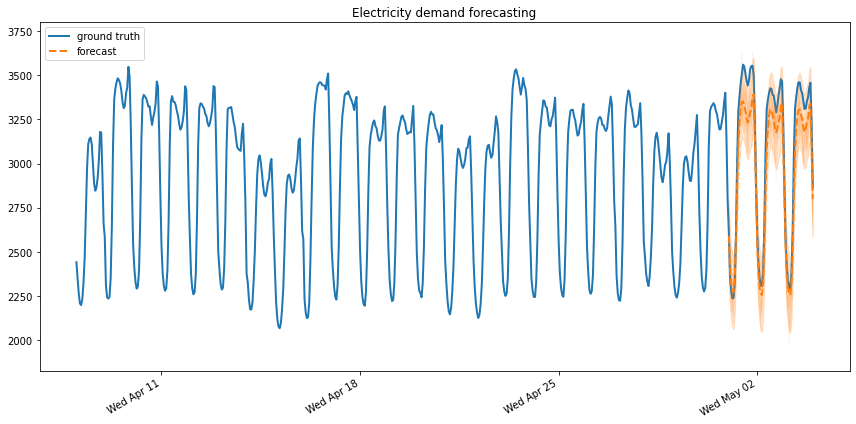

time: 313 ms (started: 2021-07-01 19:07:09 +00:00)


In [167]:
demand_loc = mdates.WeekdayLocator(byweekday=mdates.WE)
demand_fmt = mdates.DateFormatter('%a %b %d')

fig, ax = plot_forecast(dates, load_true,
                        demand_forecast_mean,
                        demand_forecast_scale,
                        demand_forecast_samples,
                        title="Electricity demand forecasting",
                        x_locator=demand_loc, x_formatter=demand_fmt)
fig.tight_layout()

In [168]:
# Remember to check for div by zero errors first
print(np.mean(np.abs((test- demand_forecast_mean) / test)) * 100)

3.7942657376669686
time: 1.19 ms (started: 2021-07-01 19:07:20 +00:00)


In [169]:
# Get the distributions over component outputs from the posterior marginals on
# training data:
component_dists = sts.decompose_by_component(
    load_model,
    observed_time_series=train,
    parameter_samples=q_samples_demand_)


time: 20 s (started: 2021-07-01 19:07:23 +00:00)


In [170]:
forecast_component_dists = sts.decompose_forecast_by_component(
    load_model,
    forecast_dist=demand_forecast_dist,
    parameter_samples=q_samples_demand_)

time: 4.13 s (started: 2021-07-01 19:07:43 +00:00)


In [171]:
demand_component_means_, demand_component_stddevs_ = (
    {k.name: c.mean() for k, c in component_dists.items()},
    {k.name: c.stddev() for k, c in component_dists.items()})

(
    demand_forecast_component_means_,
    demand_forecast_component_stddevs_
) = (
    {k.name: c.mean() for k, c in forecast_component_dists.items()},
    {k.name: c.stddev() for k, c in forecast_component_dists.items()}
    )

time: 22.1 ms (started: 2021-07-01 19:07:47 +00:00)


In [172]:
# Concatenate the training data with forecasts for plotting.
component_with_forecast_means_ = collections.OrderedDict()
component_with_forecast_stddevs_ = collections.OrderedDict()
for k in demand_component_means_.keys():
  component_with_forecast_means_[k] = np.concatenate([
      demand_component_means_[k],
      demand_forecast_component_means_[k]], axis=-1)
  component_with_forecast_stddevs_[k] = np.concatenate([
      demand_component_stddevs_[k],
      demand_forecast_component_stddevs_[k]], axis=-1)

time: 6.23 ms (started: 2021-07-01 19:07:47 +00:00)


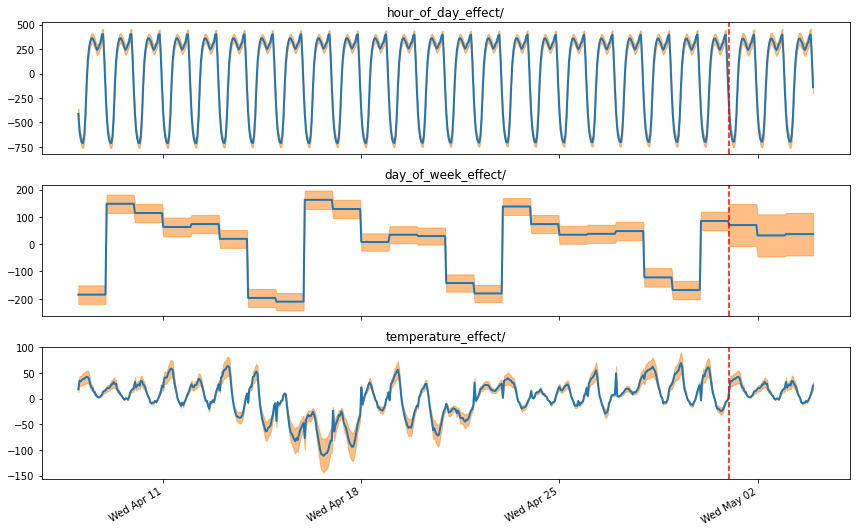

time: 634 ms (started: 2021-07-01 19:07:47 +00:00)


In [173]:
fig, axes = plot_components(
  dates,
  component_with_forecast_means_,
  component_with_forecast_stddevs_,
  x_locator=demand_loc, x_formatter=demand_fmt)
for ax in axes.values():
  ax.axvline(dates[-n_forecast_steps], linestyle="--", color='red')

# Reading Material

https://www.tensorflow.org/tutorials/structured_data/time_series

https://juanitorduz.github.io/intro_sts_tfp/

https://github.com/tensorflow/probability/tree/main/tensorflow_probability/examples

https://multithreaded.stitchfix.com/blog/2016/04/21/forget-arima/

https://en.wikipedia.org/wiki/Time_series

https://www.tensorflow.org/probability/api_docs/python/tfp/vi

https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc

https://earthobservatory.nasa.gov/features/WxForecasting

https://robjhyndman.com/hyndsight/forecasting-competitions/

https://en.wikipedia.org/wiki/Autocorrelation

https://en.wikipedia.org/wiki/Partial_autocorrelation_function

https://www.jmlr.org/papers/volume19/18-009/18-009.pdf

https://arxiv.org/abs/1206.1901

Dataset source: Tao Hong, Pierre Pinson, Shu Fan, Hamidreza Zareipour, Alberto Troccoli and Rob J. Hyndman, "Probabilistic energy forecasting: Global Energy Forecasting Competition 2014 and beyond", International Journal of Forecasting, 2016.

https://www.ge.com/power/future-of-energy

https://www.ge.com/news/reports/part-1-transformation-change-energy-ecosystem